<h1 align='center'> SMC - TD7 </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>


## MCMC

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

## Question 1
On adopte la notation (moyenne-variance) de la loi gaussienne: $\mathcal{N}(m, \sigma^2)$

Soit $(X_1, X_2)$ un vecteur aléatoire continu ayant pour densité:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{1 - \rho^2}x_1^2 + x_2^2 - 2\rho x_1 x_2\right) $$
$$ \quad = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(-(x_1, x_2)^\top M (x_1, x_2)\right) $$
Où $$M = \frac{1}{1 - \rho^2}\begin{pmatrix} 1 & -\rho \\ -\rho & 1 \end{pmatrix}$$
dont le déterminant est $|M| = 1 - \rho^2 \neq 0$ dès que $\rho \neq \pm 1$

Ainsi, p est bien la densité d'un vecteur gaussien centré de matrice de covariance: $$\Gamma = M^{-1} = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$$

## Question 2

En intégrant par rapport à $x_1$ on trouve $x_2 \sim \mathcal{N}(0, 1)$. Et de même pour $x_2$.
Comme le vecteur est continu admettant des densités, les densités des lois conditionnelles sont données par:
$p(x_1|x_2) = \frac{p(x_1, x_2)}{p(x_2)} $ et on a:
$$(X_1 | X_2 = x_2) \sim \mathcal{N}(\rho x_2, 1 - \rho^2) $$
$$(X_2 | X_1 = x_1) \sim \mathcal{N}(\rho x_1, 1 - \rho^2) $$


In [2]:
def gibbs_sampler(N, rho, init_x1=0., seed=None):
    """Gibbs sampler for (X_1, X_2)."""
    rnd = np.random.RandomState(seed)
    X = np.zeros((N, 2)) # Echantillon final (X_1, X_2)
    std = np.sqrt(1 - rho ** 2)
    
    # (X_1, X_2)_0 
    X[0, 0] = init_x1
    X[0, 1] = std * rnd.randn() + rho * init_x1 

    for i in range(1, N):
        X[i, 0] = std * rnd.randn() + rho * X[i - 1, 1]
        X[i, 1] = std * rnd.randn() + rho * X[i, 0]
    
    return X


In [3]:
N = 10000
rho = 0.5
X = gibbs_sampler(N, rho=rho)

Pour visualiser les contours-plots, il faut évaluer la densité p en chaque couple $(x_1, x_2)$.
D'abord, pour la densité cible:

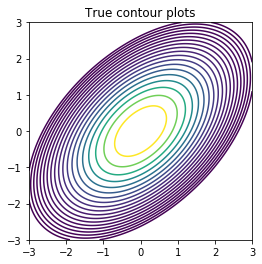

In [4]:
from scipy.stats import multivariate_normal
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

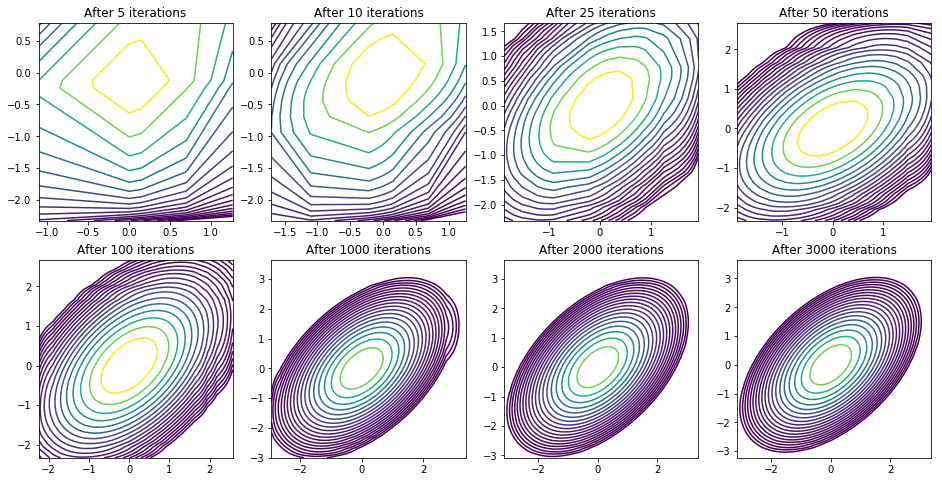

In [5]:
f, axes = plt.subplots(2, 4, figsize=(16, 8))
ns = [5, 10, 25, 50, 100, 1000, 2000, 3000]
for ax, n in zip(axes.ravel(), ns):
    X1grid, X2grid = np.meshgrid(sorted(X[:n, 0]), sorted(X[:n, 1]))
    pos = np.empty((n, n, 2))
    pos[:, :, 0] = X1grid
    pos[:, :, 1] = X2grid
    Z = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    ax.contour(X1grid, X2grid, Z, levels=np.logspace(-2, 0., 20) * Z_true.max())
    ax.set_title("After %d iterations" % n)
plt.show()

Now we plot autocorrelations:

In [6]:
lags = 100
corrs = np.empty((lags, 2))
n = len(X)
for lag in range(lags):
    c1 = np.corrcoef(X[lag:, 0], X[:n - lag, 0])[0, 1]
    c2 = np.corrcoef(X[lag:, 1], X[:n - lag, 1])[0, 1]
    corrs[lag] = c1, c2

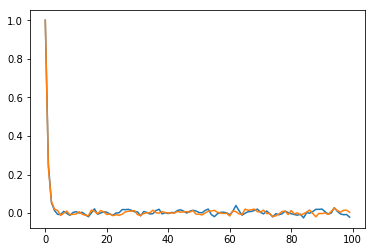

In [7]:
plt.figure()
plt.plot(corrs)
plt.show()

This suggests that we should pick one sample every (at least) 10 iterations or so:

In [8]:
N = 10000
rho = 0.5
X = gibbs_sampler(N, rho=rho)

# Take every 1 sample every 10 iterations:
X = X[10::10, :]

Now with $rho \to 1$:

In [9]:
N = 10000
rho = 0.99
X = gibbs_sampler(N, rho=rho)

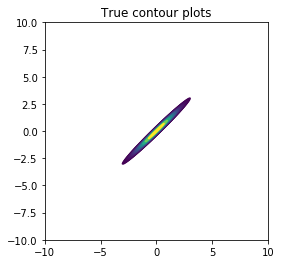

In [10]:
from scipy.stats import multivariate_normal
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-10, 10, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

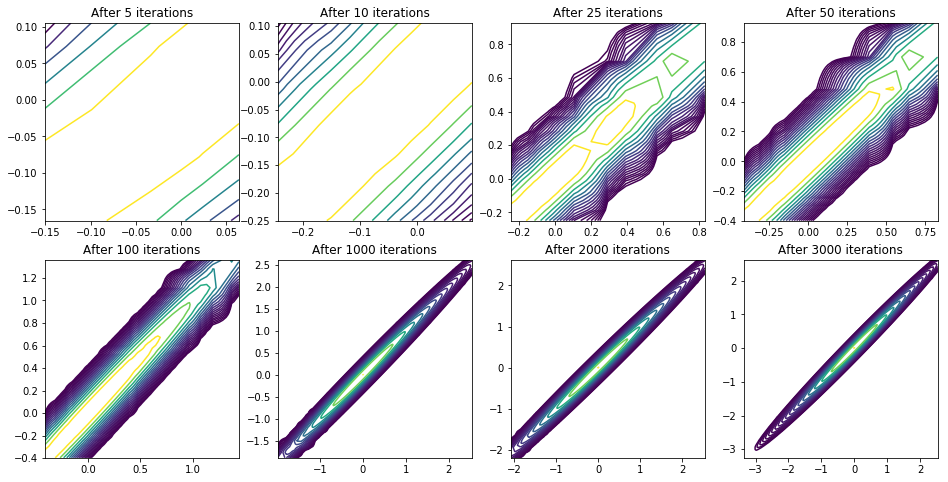

In [11]:
f, axes = plt.subplots(2, 4, figsize=(16, 8))
ns = [5, 10, 25, 50, 100, 1000, 2000, 3000, 10000]
for ax, n in zip(axes.ravel(), ns):
    X1grid, X2grid = np.meshgrid(sorted(X[:n, 0]), sorted(X[:n, 1]))
    pos = np.empty((n, n, 2))
    pos[:, :, 0] = X1grid
    pos[:, :, 1] = X2grid
    Z = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
    ax.contour(X1grid, X2grid, Z, levels=np.logspace(-2, 0., 20) * Z_true.max())
    ax.set_title("After %d iterations" % n)
plt.show()

In [12]:
lags = 1000
corrs = np.empty((lags, 2))
n = len(X)
for lag in range(lags):
    c1 = np.corrcoef(X[lag:, 0], X[:n - lag, 0])[0, 1]
    c2 = np.corrcoef(X[lag:, 1], X[:n - lag, 1])[0, 1]
    corrs[lag] = c1, c2

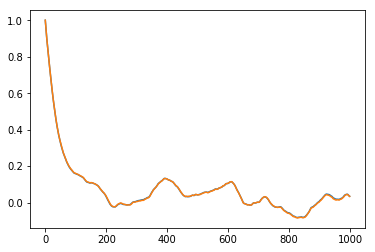

In [13]:
plt.figure()
plt.plot(corrs)
plt.show()